In [37]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [38]:
with open('names.txt', 'r') as f:
    words = f.read().splitlines()

In [39]:
ALPHABET_SIZE = 27
all_chars = sorted(list(set(''.join(words))))
stoi = {c: i+1 for i, c in enumerate(all_chars)}
stoi['.'] = 0
itos = {i: c for c, i in stoi.items()}

In [40]:
# let's prepare the data
BLOCK_SIZE = 3
def build(words):
    X = []
    Y = []
    for word in words:
        context = [0] * BLOCK_SIZE
        for letter in word + '.':
            letter_index = stoi[letter]
            X.append(context[:])
            Y.append(letter_index)
            context = context[1:] + [letter_index]
    return torch.tensor(X), torch.tensor(Y)


torch.Size([228146, 3])

In [ ]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)
X_train, Y_train = build(words[:n1])
X_valid, Y_valid = build(words[n1:n2])
X_test, Y_test = build(words[n2:])


In [71]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
EMBEDDING_SIZE = 10
C = torch.randn((ALPHABET_SIZE, EMBEDDING_SIZE), generator=g, requires_grad=True)

In [72]:
HIDDEN_LAYER_OUTPUTS = 200
W1 = torch.randn((EMBEDDING_SIZE * BLOCK_SIZE, HIDDEN_LAYER_OUTPUTS), generator=g, requires_grad=True)
b1 = torch.randn((HIDDEN_LAYER_OUTPUTS), generator=g, requires_grad=True)

In [73]:
W2 = torch.randn((HIDDEN_LAYER_OUTPUTS, ALPHABET_SIZE), generator=g, requires_grad=True)
b2 = torch.randn((ALPHABET_SIZE), generator=g, requires_grad=True)

In [74]:
parameters = [C, W1, b1, W2, b2]

In [75]:
BATCH_SIZE = 32

def step(X, Y, sc):

    batch_indices = torch.randint(0, X.shape[0], (BATCH_SIZE,))
    batchX = X[batch_indices]
    batchY = Y[batch_indices]
    # forward pass
    
    embeddings = C[batchX]
    hidden_outputs = (embeddings.view(-1, EMBEDDING_SIZE * BLOCK_SIZE) @ W1 + b1).tanh()
    outputs = hidden_outputs @ W2 + b2
    loss = F.cross_entropy(outputs, batchY)

    # backward pass
    for param in parameters:
        param.grad = None
    
    loss.backward()

    # update params
    LEARNING_RATE = 0.1 if sc < 100_000 else 0.01
    for param in parameters:
        param.data += -LEARNING_RATE * param.grad
    return loss.item()

In [76]:
steps = []
losses = []

Step 10000: loss 2.470569372177124
Step 20000: loss 2.72412109375
Step 30000: loss 2.172492504119873
Step 40000: loss 2.758690118789673
Step 50000: loss 2.6549386978149414
Step 60000: loss 2.5502572059631348
Step 70000: loss 2.338013172149658
Step 80000: loss 1.908426284790039
Step 90000: loss 1.8035835027694702
Step 100000: loss 2.4789180755615234
Step 110000: loss 2.167339324951172
Step 120000: loss 2.0131263732910156
Step 130000: loss 1.6652344465255737
Step 140000: loss 1.884928822517395
Step 150000: loss 2.1991190910339355
Step 160000: loss 1.973751187324524
Step 170000: loss 2.1544389724731445
Step 180000: loss 2.1477363109588623
Step 190000: loss 1.9382455348968506
Step 200000: loss 1.9254928827285767


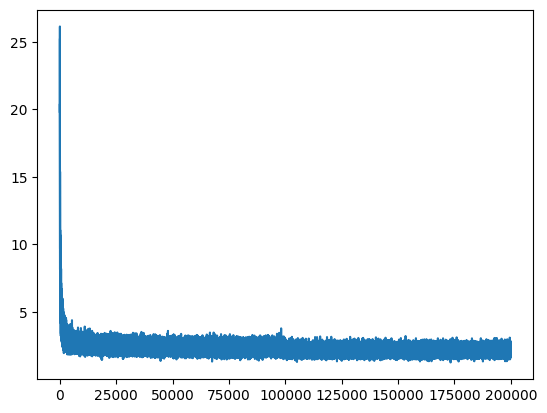

In [77]:
for _ in range(200000):
    step_num = len(steps) + 1
    steps.append(step_num)
    loss = step(X_train, Y_train, step_num)
    losses.append(loss)
    if step_num % 10000 == 0:
        print(f"Step {step_num}: loss {loss}")

plt.plot(steps, losses)

In [48]:
ix = torch.randint(0, X.shape[0], (32,))
ix

tensor([191504,  30774, 117886,  74464, 119332, 187508,  68037, 116351, 191807,
         78769,   9180,  45456,  55077,   6994,  75062, 105234, 216701,  67355,
         61600,  43977, 197830, 115280,  37263,  87258, 133865,  30912, 160813,
         17115, 147313, 192363,  10944, 224671])

In [78]:
def calculate_loss(X, Y):
    embeddings = C[X]
    hidden_outputs = (embeddings.view(-1, EMBEDDING_SIZE * BLOCK_SIZE) @ W1 + b1).tanh()
    outputs = hidden_outputs @ W2 + b2
    loss = F.cross_entropy(outputs, Y)
    print(loss.item())

1.9254928827285767

In [ ]:
calculate_loss(X_train, Y_train)

In [ ]:
calculate_loss(X_valid, Y_valid)